In [1]:
import numpy as np
import pandas as pd
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from matplotlib import pyplot as plt
from numpy.random import seed

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
df = pd.read_csv("dataAirbnb.csv")

In [4]:
df.head()

,Annual Revenue LTM (USD),Occupancy Rate LTM,Number of Bookings LTM,Number of Reviews,Bedrooms,Bathrooms,Max Guests,Response Rate,Airbnb Superhost,Cancellation Policy,...,Number of Photos,Instantbook Enabled,Overall Rating,Airbnb Accuracy Rating,Pets Allowed,Airbnb Property ID,Days on Platform,Year,Days on AirBNB,Occupancy Rate
0,930.0,0.167,1.0,167.0,3.0,2.0,8.0,90.0,False,strict_14_with_grace_period,...,25.0,False,92.0,9.0,False,2915068.0,2103 days,2020.0,2103,0
1,1684.0,0.462,3.0,71.0,1.0,1.5,1.0,100.0,False,moderate,...,20.0,False,97.0,10.0,False,2924834.0,2101 days,2020.0,2101,0
2,3365.0,0.233,1.0,5.0,2.0,2.0,6.0,90.0,False,moderate,...,18.0,False,92.0,9.0,False,2928315.0,2100 days,2020.0,2100,0
3,344.0,0.065,2.0,133.0,0.0,1.0,2.0,100.0,False,strict_14_with_grace_period,...,16.0,False,92.0,9.0,False,2931165.0,2099 days,2020.0,2099,0
4,845.0,0.054,2.0,49.0,3.0,2.0,8.0,100.0,False,strict_14_with_grace_period,...,49.0,False,88.0,9.0,False,2931271.0,2099 days,2020.0,2099,0


In [5]:
df.drop(labels=['Airbnb Property ID','Occupancy Rate LTM','Days on Platform', 'Year'], axis=1)

,Annual Revenue LTM (USD),Number of Bookings LTM,Number of Reviews,Bedrooms,Bathrooms,Max Guests,Response Rate,Airbnb Superhost,Cancellation Policy,Cleaning Fee (USD),Published Nightly Rate (USD),Minimum Stay,Count Reservation Days LTM,Number of Photos,Instantbook Enabled,Overall Rating,Airbnb Accuracy Rating,Pets Allowed,Days on AirBNB,Occupancy Rate
0,930.0,1.0,167.0,3.0,2.0,8.0,90.0,False,strict_14_with_grace_period,100.0,140.0,2.0,4.0,25.0,False,92.0,9.0,False,2103,0
1,1684.0,3.0,71.0,1.0,1.5,1.0,100.0,False,moderate,30.0,54.0,21.0,42.0,20.0,False,97.0,10.0,False,2101,0
2,3365.0,1.0,5.0,2.0,2.0,6.0,90.0,False,moderate,250.0,445.0,2.0,7.0,18.0,False,92.0,9.0,False,2100,0
3,344.0,2.0,133.0,0.0,1.0,2.0,100.0,False,strict_14_with_grace_period,25.0,49.0,1.0,6.0,16.0,False,92.0,9.0,False,2099,0
4,845.0,2.0,49.0,3.0,2.0,8.0,100.0,False,strict_14_with_grace_period,75.0,139.0,2.0,5.0,49.0,False,88.0,9.0,False,2099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63799,486.0,0.0,4.0,2.0,2.0,6.0,0.0,False,moderate,99.0,199.0,1.0,3.0,17.0,False,65.0,7.0,True,0,0
63800,2985.0,3.0,1.0,2.0,2.5,4.0,100.0,False,moderate,70.0,75.0,1.0,37.0,14.0,True,100.0,10.0,True,0,1
63801,2240.0,3.0,4.0,1.0,1.5,2.0,100.0,False,moderate,50.0,55.0,1.0,38.0,13.0,True,100.0,10.0,True,0,1
63802,260.0,0.0,5.0,1.0,1.5,4.0,100.0,False,strict_14_with_grace_period,50.0,80.0,1.0,3.0,11.0,False,68.0,8.0,False,0,0


In [6]:
X_cols = ['Annual Revenue LTM (USD)','Number of Bookings LTM', 'Number of Reviews', 'Bedrooms', 'Bathrooms',
       'Max Guests', 'Response Rate','Cleaning Fee (USD)','Published Nightly Rate (USD)', 'Minimum Stay',
       'Count Reservation Days LTM', 'Number of Photos','Overall Rating', 'Airbnb Accuracy Rating','Days on AirBNB',
            'Airbnb Superhost','Cancellation Policy','Instantbook Enabled','Pets Allowed']

Y_cols = ['Occupancy Rate']

In [7]:
X_data = df[X_cols].copy()
Y_data = df[Y_cols].copy()

In [8]:
X_data = pd.get_dummies(X_data, columns=['Airbnb Superhost','Cancellation Policy','Instantbook Enabled',
                                        'Pets Allowed'], drop_first=True)

In [9]:
X_data = np.array(X_data)
y_data = np.array(Y_data)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,random_state=1, test_size=0.2)

In [11]:
# Instantiate encoder/scaler
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

# k Nearest Neighbour

In [12]:
clf_kNN = KNeighborsClassifier()
clf_kNN.fit(X_train, y_train.ravel())

KNeighborsClassifier()

In [13]:
kNN_train_predict = clf_kNN.predict(X_train)

In [14]:
print("f1_score on the training set: %f" % f1_score(y_train, kNN_train_predict, average="weighted"))

f1_score on the training set: 0.821203


In [15]:
#COmputing mean of the five fold cross validation score
sc = cross_val_score(clf_kNN, X_train, y_train.ravel(),scoring="f1_weighted", cv=3)
print("Cross Validation scores: ", sc)
print("Cross Validation scores mean: ", sc.mean())

Cross Validation scores:  [0.74451883 0.74168134 0.74767317]
Cross Validation scores mean:  0.7446244474004388


In [16]:
def plot_learning_curve(estimator,title,X,y,axes=None,ylim=None,cv=None,n_jobs=None,
                        train_sizes=np.linspace(0.1, 1.0, 5),):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,
        train_sizes=train_sizes,scoring="f1_weighted",return_times=True,)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [25]:
param_grid = {
    'n_neighbors': [5, 10, 50, 100],
    "weights": ['uniform','distance']
}
estimator = KNeighborsClassifier(algorithm='auto',metric='minkowski')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 1, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, Y_train.ravel())

#First grid search
grid1 = grid_search.best_estimator_
f1_score1 = grid_search.best_score_
print("Best estimator: ", grid1)
print("\n")
print("Best f1 score: ", f1_score1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.0min finished


Best estimator:  KNeighborsClassifier(weights='distance')


Best f1 score:  0.9880003074403627


In [26]:
param_grid = {
    'n_neighbors': [1, 5, 8],
    "weights": ['distance']
}
estimator = KNeighborsClassifier(algorithm='auto',metric='minkowski')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 1, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, Y_train.ravel())

#First grid search
grid2 = grid_search.best_estimator_
f1_score2 = grid_search.best_score_
print("Best estimator: ", grid2)
print("\n")
print("Best f1 score: ", f1_score2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Best estimator:  KNeighborsClassifier(n_neighbors=1, weights='distance')


Best f1 score:  0.9958771451276294


In [ ]:
#Choose the best f1 score
estimators=[grid1, grid2]
for estimator in estimators:
    
    #Shuffle Split = Stratifold strategy
    title1 = "f1 score Learning curve with Stratifold CV strategy"
    plot_learning_curve(estimator, title1, X_train, Y_train.ravel(), axes=None, ylim=(0.7, 1.01),
                    cv=None, n_jobs=-1)

    #Shuffle Split with n_splits=10
    title2 = "f1 score Learning curve with n_splits=10 CV strategy"
    cv= ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    plot_learning_curve(estimator, title2, X_train, Y_train.ravel(), axes=None, ylim=(0.7, 1.01),
                cv=cv, n_jobs=-1)

In [17]:
def complexity_curve(train_scores, validation_scores, index, title, inverse_x=False):
    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(index, train_scores , "r-+",label="Train")
    plt.plot(index, test_scores, "g-+",label="Validation")
    plt.title(title)
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    #plt.gca().invert_xaxis()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


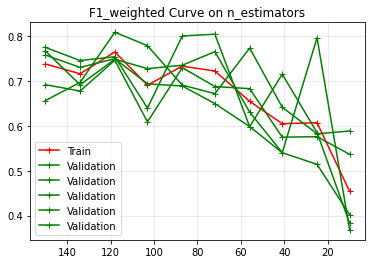

In [33]:
#Using the validation curve determine the best alpha
neigh = KNeighborsClassifier(algorithm='auto', metric='minkowski',metric_params=None, 
                             n_neighbors=100, weights='uniform')

param_range = [5,10,50]

train_scores, test_scores = validation_curve(neigh, X_train, Y_train.ravel(), param_name="n_neighbors", 
    param_range=param_range, scoring='f1_weighted', verbose=1, cv=5, n_jobs=-1)
train_scores.mean(axis=1), test_scores.mean(axis=1), param_range
complexity_curve(train_scores.mean(axis=1), test_scores.mean(axis=1), param_range, 
                title='F1_weighted Curve on n_neighbors', inverse_x=True)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

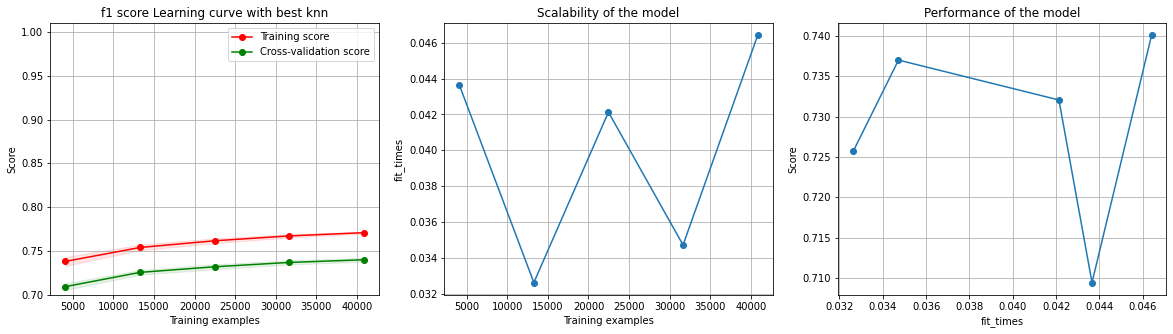

In [19]:
#Determining the best boosted tree
clf_knn = KNeighborsClassifier(algorithm='auto', metric='minkowski',metric_params=None, 
                             n_neighbors=10, weights='uniform')


#Shuffle Split with stratifold
title2 = "f1 score Learning curve with best knn"
cv_dT= ShuffleSplit(test_size=0.2, random_state=0)
plot_learning_curve(clf_knn, title2, X_train, y_train.ravel(), axes=None, ylim=(0.7, 1.01),
                cv=cv_dT, n_jobs=-1)

In [22]:
clf_knn.fit(X_train, y_train.ravel())
predict_decision = clf_knn.predict(X_test)


#Print results
print(classification_report(y_test, predict_decision))
print("f1 score: ", f1_score(y_test, predict_decision, average="weighted"))
print()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, predict_decision).flatten()
type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100
print("True Negative, False Positive, False Negative, True Positive: ", tn_test, fp_test, fn_test, tp_test)
print()
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)
print()
      
probs_dc = clf_knn.predict_proba(X_test)
probs_dc = probs_dc[:, 1]
auc = roc_auc_score(y_test, probs_dc)
print('AUC: %.3f' % auc)

              precision    recall  f1-score   support

           0       0.79      0.96      0.86      9269
           1       0.73      0.31      0.43      3492

    accuracy                           0.78     12761
   macro avg       0.76      0.63      0.65     12761
weighted avg       0.77      0.78      0.74     12761

f1 score:  0.7446320577919995

True Negative, False Positive, False Negative, True Positive:  8872 397 2424 1068

Type I error:  69.41580756013745
Type II error:  4.283094184917468

AUC: 0.736
